In [1]:
# %load defaults.ipy
# %load defaults.ipy
import sys
import os
for p in sys.path:
    if 'netcdf' in p.lower():
        sys.path.remove(p)
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 300
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import PIL

def console_print(message):
    
    message = str(message)
    with open('/dev/stdout', 'w') as f:
        f.write("\n\n---------------DEBUG INFORMATION---------------\n")
        f.write(message + '\n')
        f.write("\n---------------END   INFORMATION---------------\n\n")
        f.flush()


def writeMetadata(filename, data):
    im = PIL.Image.open(filename)
    
    meta = PIL.PngImagePlugin.PngInfo()

    for key in data.keys():
        meta.add_text(key, data[key])
    im.save(filename, "png", pnginfo=meta)

    
def save(name):
    name = save.prefix + "_" + 'kh_time_average' + name
    name = ''.join(ch for ch in name if ch.isalnum() or ch =='_')
    fig = plt.gcf()
    ax = plt.gca()
    ax.text(0.95, 0.01, 'By Kjetil Olsen Lye\nkjetil.o.lye@gmail.com',
         fontsize=3, color='gray',
         ha='right', va='bottom', alpha=0.5, transform=ax.transAxes)

    matplotlib2tikz.save('img_tikz/' + name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth',
                        show_info=False)
    
    savenamepng = 'img/' + name + '.png'
    plt.savefig(savenamepng, bbox_inches="tight")
    
    writeMetadata(savenamepng, {'Copyright' : 'Copyright, Kjetil Olsen Lye kjetil.o.lye@gmail.com'
                               })
save.prefix=''
def showAndSave(name):
    save(name)
    plt.show()
    
 
    
def legendLeft():
    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def load(filename, variable):
    with netCDF4.Dataset(filename) as f:
        return f.variables[variable][:,:,0]

In [2]:
import sys
sys.path.append("/cluster/home/klye/alsvinn/build/python/")
sys.path.append("/home/kjetil/projects/alsvinn/build/python/")
import alsvinn

In [3]:
import re
def computeConvergence(basename, normP, allFiles, showSingle=False, showRes=False, statistics='mean', 
                       upTo=-1, var='rho', title_base=''):
    # This run always fails, so we skip it
    if 'nieder' in basename or 'latin_center' in basename:
        return
    if 'kelvinhelmholtz' in basename:
        name = re.search(r'kelvinhelmholtz_time_4_([^/]+)\/', basename).group(1)
    else:
        name = re.search(r'euler_brownian_([^/]+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 256
    if showSingle:
        display(HTML("<h1>%s</h1>" % name))
    
    exponents = list(range(6,16))
    Ms = 2**array(exponents)
    
    plotted_names = {}
    
    Ts = [0]
    NT = len(Ts)
    for t in Ts:
        plt.figure(t)
        plotted_names[t] = 'cauchy_convergence_%d_%d_%s' % (normP, t, statistics)
        errors = []
        
        for M in Ms:
            filename = basename.format(M=M)
            
            mean = load(filename, var)
            
            
            if M > Ms[0]:
                errors.append((sum(abs(mean-meanPrev)**normP)/mean.shape[0]**2)**(1.0/normP))
            meanPrev = mean
            if showRes:
                x,y = mgrid[0:1:N*1j, 0:1:N*1j]
                plt.pcolormesh(x,y, mean)
                plt.ylabel('$y$')
                plt.xlabel('$x$')
                plt.title((title_base +" (variable: " + var + ")\n") + '%s, $M=%d$' % (name, M))
                plt.colorbar()
                showAndSave('single_%s_%d_%s_%d' % (name, M, statistics, t))
        p = plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[:-1]), log(errors), 1)
        
        plt.loglog(Ms[:-1], exp(poly[1])*Ms[:-1]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
        
        if not showSingle:
            plt.title((title_base +" (variable: " + var + ")\n") + "Cauchy convergence \n%s\nresolution=$256 \\times 256$" % ( statistics))
        legendLeft()
        if showSingle:
            
            plt.title((title_base +" (variable: " + var + ")\n") + "Cauchy Convergence for %s \n%s\nresolution=$256 \\times 256$" % (name, statistics))
            showAndSave('cauchy_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
    
    for t in Ts:
        filename = basename.format(M=Ms[-1])
        
        errors = []
        plt.figure(NT+t)
        plotted_names[NT+t] = 'reference_convergence_%d_%d_%s' % (normP, t, statistics)
        
        referenceSolution = load(filename, var)
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            mean = load(filename, var)
               
            
            
            errors.append((sum(abs(mean-referenceSolution)**normP)/mean.shape[0]**2)**(1.0/normP))
           
        p = plt.loglog(Ms[:upTo], errors, '-o',label=name)
        poly = polyfit(log(Ms[:upTo]), log(errors), 1)
        
        plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
        if not showSingle:
            plt.title((title_base +" (variable: " + var + ")\n") + 
                      "Self convergence against reference solution $M=%d$\n%s\nresolution=$256 \\times 256$" % 
                      (Ms[-1],  statistics))
        
        legendLeft()
        if showSingle:
            plt.title((title_base +" (variable: " + var + ")\n") + 
                      "Self convergence for %s \nagainst reference solution with $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (name,Ms[-1],statistics))
            showAndSave('self_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
            
            
    for t in Ts:
        
        try:
            for f in allFiles:
                if 'monte_carlo' in f:
                    mc_filename = f
                    break
            mc_samples = Ms[-1]
            filename = mc_filename.format(M=mc_samples)
            referenceSolution = load(filename, var)
        except Exception as e:
            print("%s failed, see error message below: " % name)
            print (e)
            return
        errors = []
        plt.figure(2*NT+t)
       
        plotted_names[2*NT+t] = 'mc_convergence_%d_%d_%s' % (normP, t, statistics)
       
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            
            mean = load(filename, var)
               
            
            
            errors.append((sum(abs(mean-referenceSolution)**normP)/mean.shape[0]**2)**(1.0/normP))
           
        p = plt.loglog(Ms[:upTo], errors, '-o',label=name)
        poly = polyfit(log(Ms[:upTo]), log(errors), 1)
        
        plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
        if not showSingle:
            plt.title((title_base +" (variable: " + var + ")\n") + 
                      "Convergence against reference solution\ngenerated with Monte-Carlo\nwith $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (mc_samples,  statistics))
        
        legendLeft()
        if showSingle:
            plt.title((title_base +" (variable: " + var + ")\n") + "Convergence for %s \nagainst reference solution MC\n%s\nresolution=$256 \\times 256$" % (name, statistics))
            showAndSave('mc_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
    
    
    for t in Ts:
        
        errors_max = []
        errors_mean = []
        errors_min = []
        
       
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            
            mean = load(filename, var)
               
            error_mean = 0
            error_min = 100000000
            error_max = -error_min
            number_of_files = 0
            for f in allFiles:
                try:
                    
                    filename = f.format(M=Ms[-1])
                    
                    meanReference = load(filename, var)
                except Exception as e:
                    print("%s failed, see error message below: " % f)
                    print(e)
                    continue
                error = (sum(abs(mean-meanReference)**normP)/mean.shape[0]**2)**(1.0/normP)
                
                error_mean += error
                error_min = min(error_min, error)
                error_max = max(error_max, error)
                number_of_files +=1
            error_mean /= number_of_files
            errors_max.append(error_max)
            errors_min.append(error_min)
            errors_mean.append(error_mean)
                
        if not showSingle:
            plt.figure(6*NT+t)
            plotted_names[6*NT+t] = 'worst_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_max, '-o',label=name)
            poly = polyfit(log(Ms[:upTo]), log(errors_max), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
            plt.title((title_base +" (variable: " + var + ")\n") +
                      "\"Worst case\" convergence against reference solution\n\nwith $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (Ms[-1], statistics))
        
        
            plt.figure(8*NT+t)
            plotted_names[8*NT+t] = 'best_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_min, '-o',label=name)
            poly = polyfit(log(Ms[:upTo]), log(errors_min), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
            plt.title((title_base +" (variable: " + var + ")\n") +
                      "\"Best case\" convergence against reference solution\n\nwith $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (Ms[-1], statistics))
        
        
            plt.figure(10*NT+t)
            plotted_names[10*NT+t] = 'mean_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_mean, '-o',label=name)
            poly = polyfit(log(Ms[:upTo]), log(errors_mean), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
            plt.title((title_base +" (variable: " + var + ")\n") + "\"Average\" convergence against reference solution\n\nwith $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (Ms[-1], statistics))
        
        else:
            p = plt.loglog(Ms[:upTo], errors_max, '-o',label="worst case error")
            poly = polyfit(log(Ms[:upTo]), log(errors_max), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
            
            
            p = plt.loglog(Ms[:upTo], errors_min, '-o',label="best case error")
            poly = polyfit(log(Ms[:upTo]), log(errors_min), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
            
        
            
            p = plt.loglog(Ms[:upTo], errors_mean, '-o',label="average error")
            poly = polyfit(log(Ms[:upTo]), log(errors_mean), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
            plt.xlabel("M")
            plt.ylabel("Error ($||\\cdot||_{L^{%d}}$)" % normP)
            legendLeft()
        
            plt.title((title_base +" (variable: " + var + ")\n") + "Convergence for %s \nagainst reference solution MC\n%s\nresolution=$256 \\times 256$" % (name, statistics))
            showAndSave('best_worst_mean_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
    return plotted_names

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_0.0625_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_0.0625_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_0.0625_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_0.0625_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_0.0625_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment w

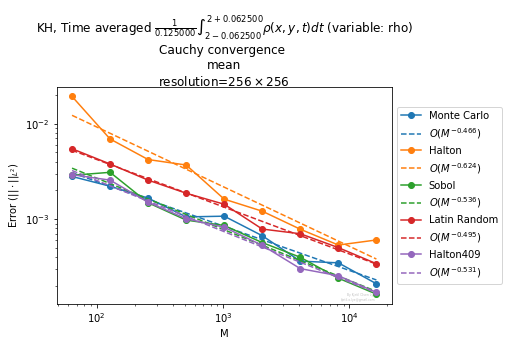

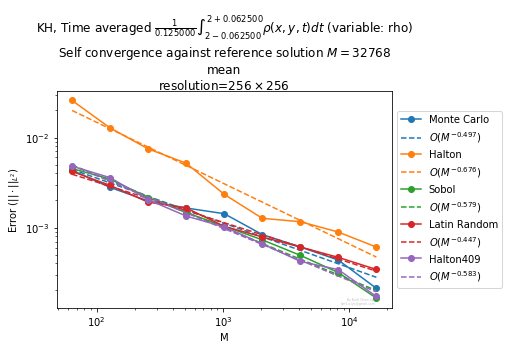

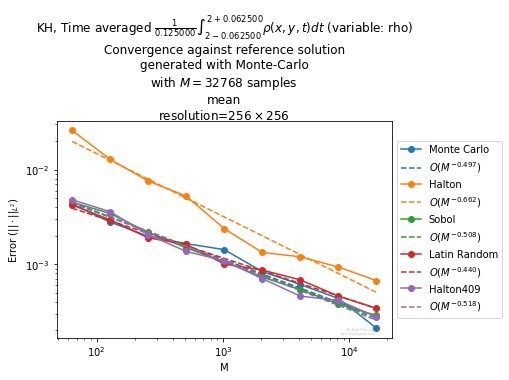

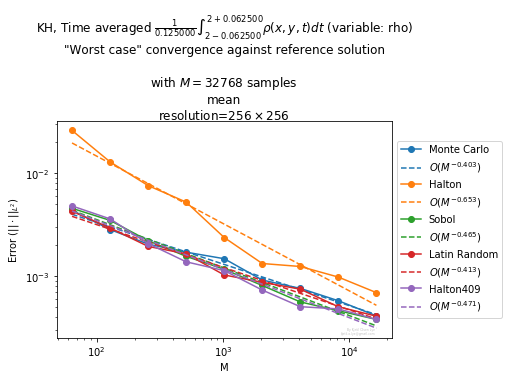

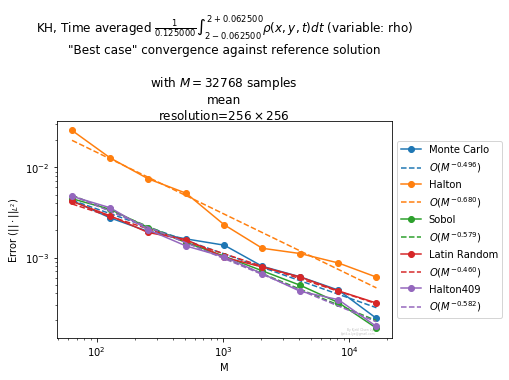

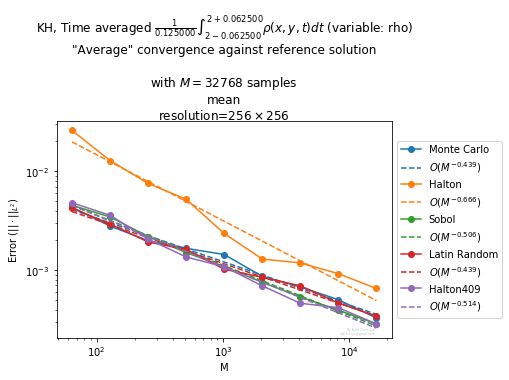

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_0.125_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_0.125_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_0.125_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_0.125_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_0.125_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will b

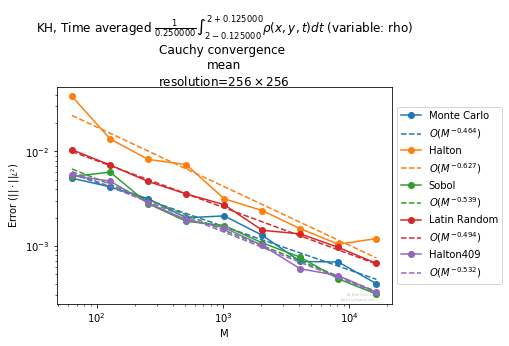

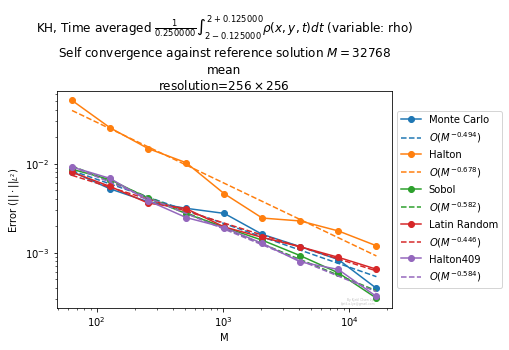

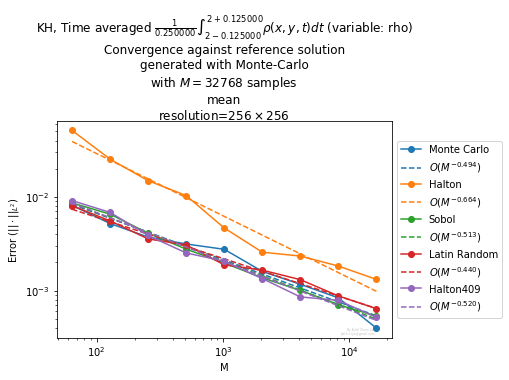

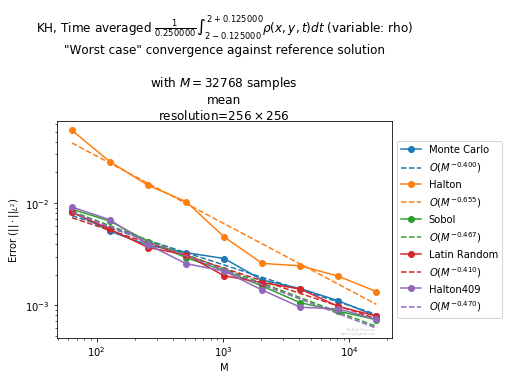

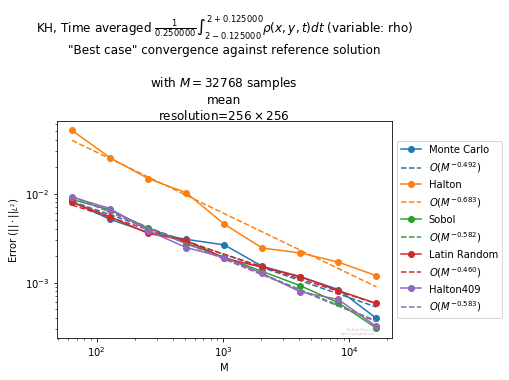

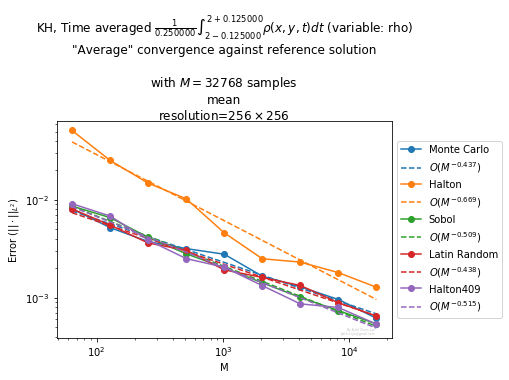

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_0.25_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_0.25_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_0.25_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_0.25_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_0.25_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ign

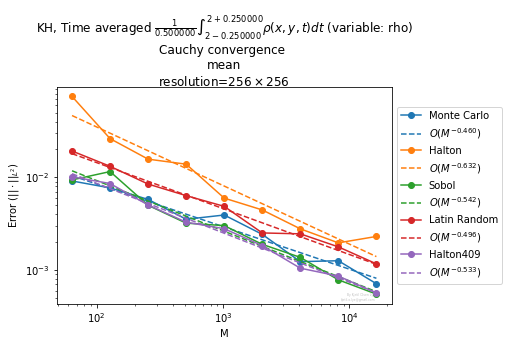

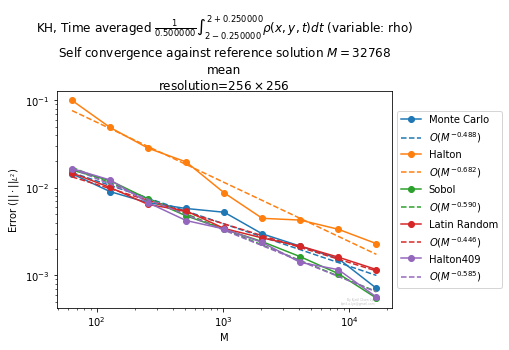

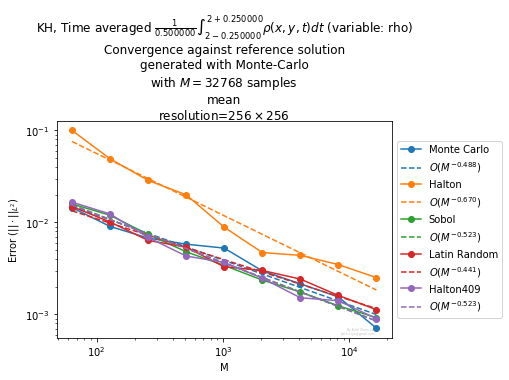

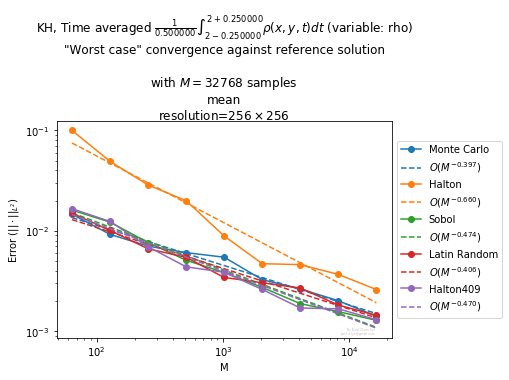

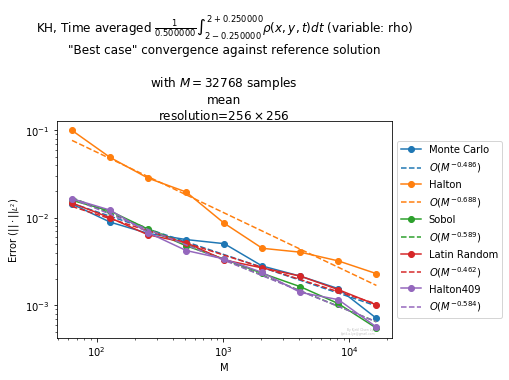

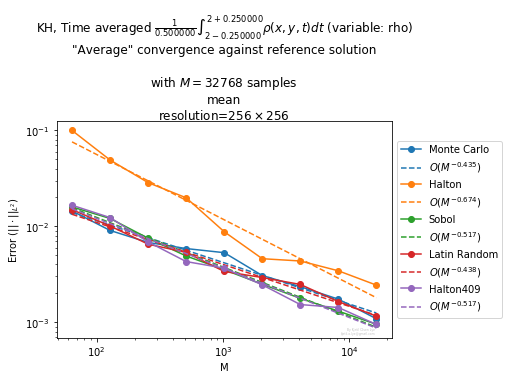

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_0.5_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_0.5_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_0.5_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_0.5_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_0.5_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored 

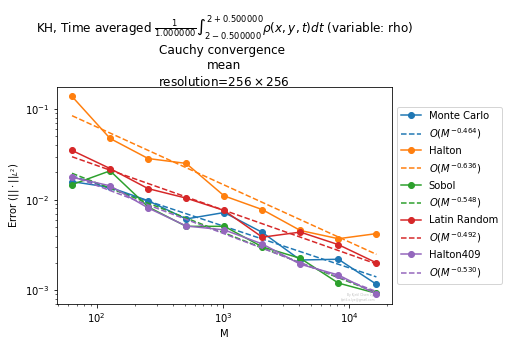

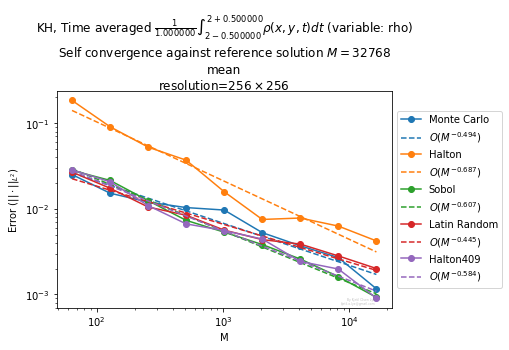

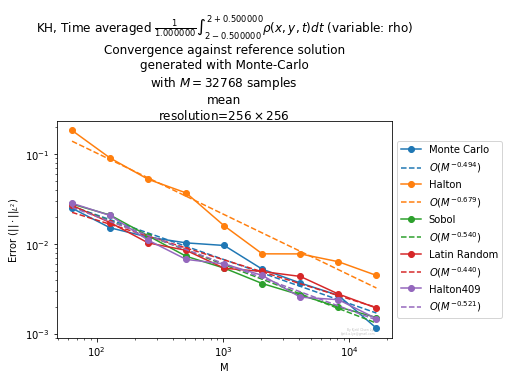

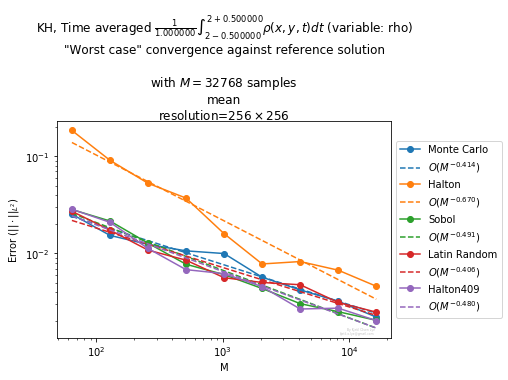

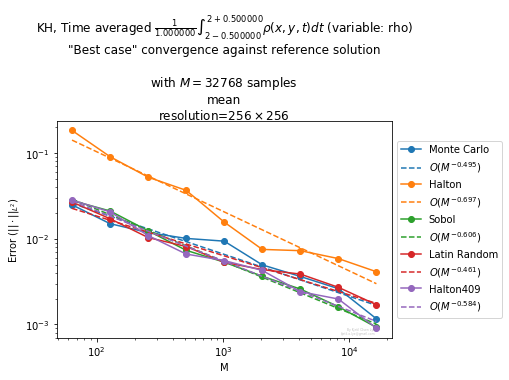

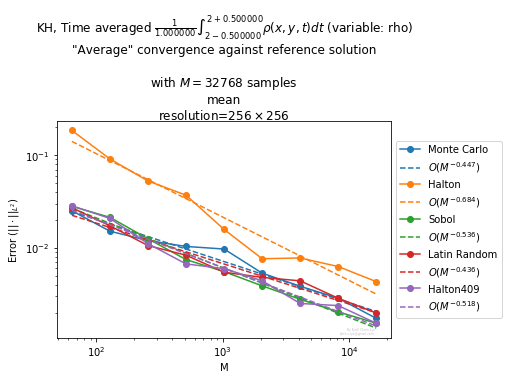

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_1.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_1.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_1.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_1.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_1.0_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored 

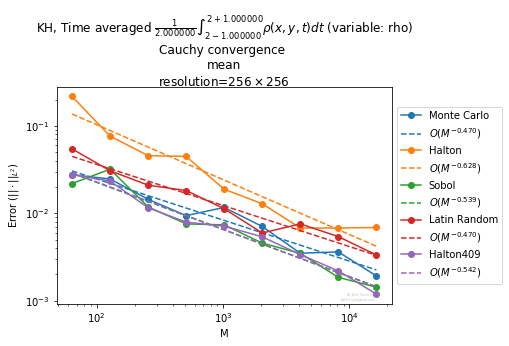

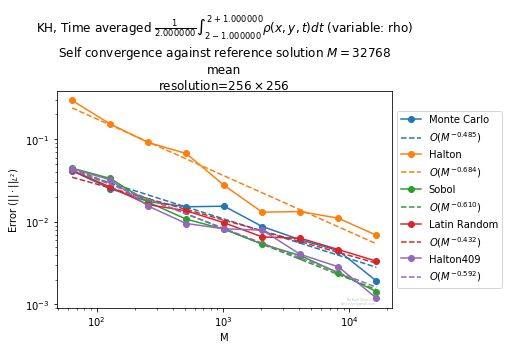

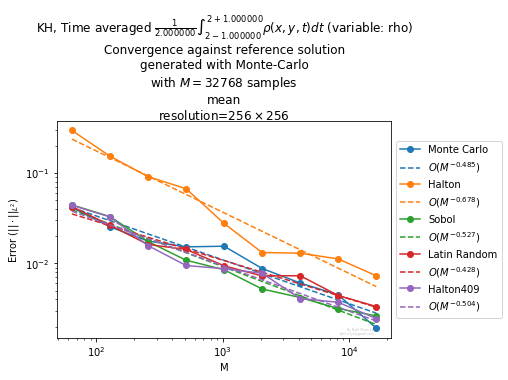

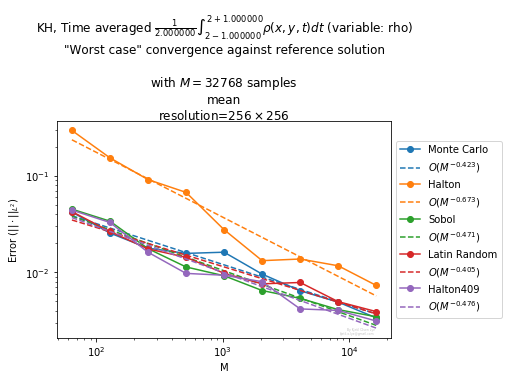

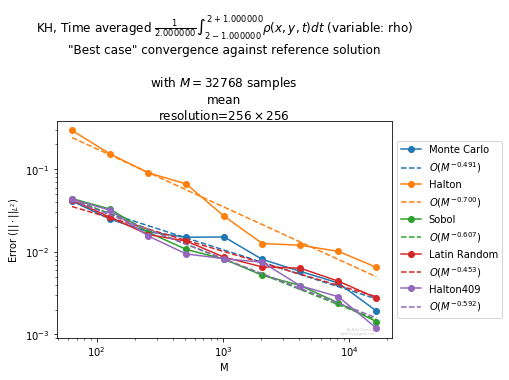

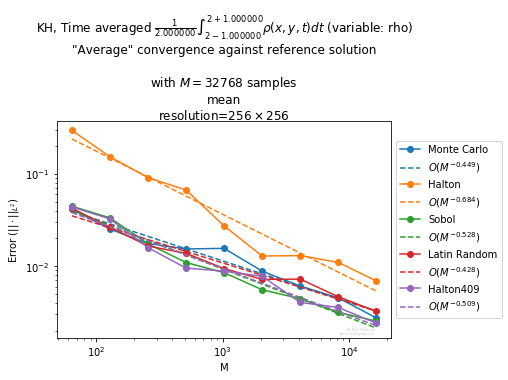

../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_monte_carlo/m{M}/kelvinhelmholtz_identity_2.0_2.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton/m{M}/kelvinhelmholtz_identity_2.0_2.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_sobol/m{M}/kelvinhelmholtz_identity_2.0_2.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_latin_random/m{M}/kelvinhelmholtz_identity_2.0_2.0_mean_identity_0.nc
../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_halton409/m{M}/kelvinhelmholtz_identity_2.0_2.0_mean_identity_0.nc
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored 

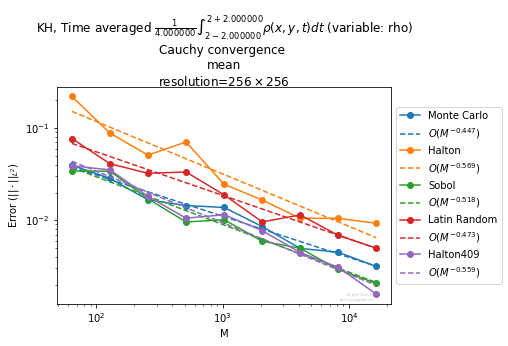

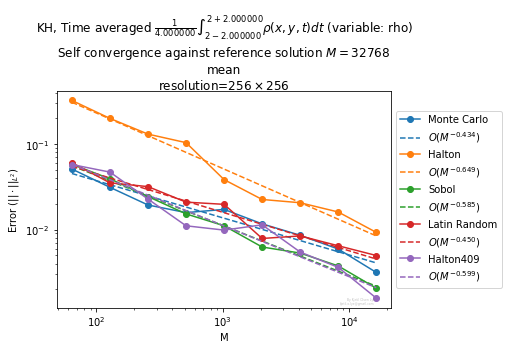

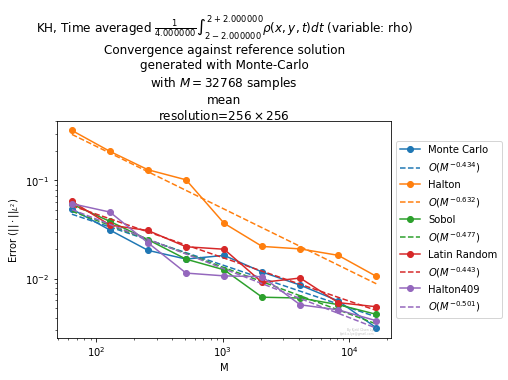

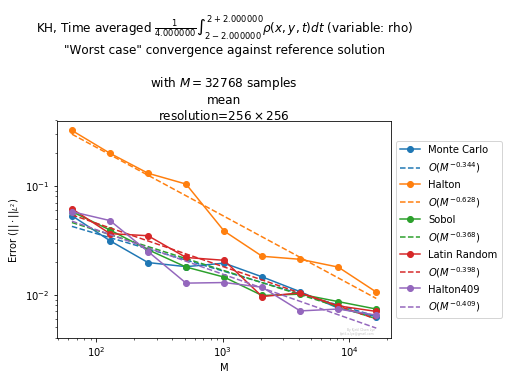

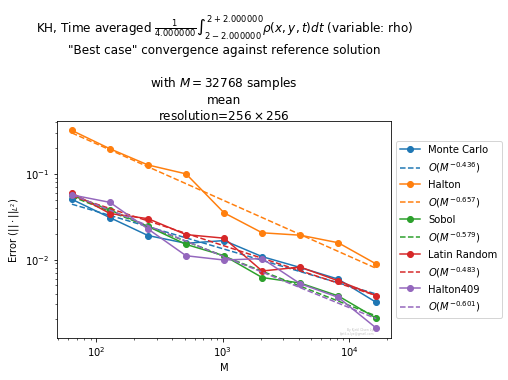

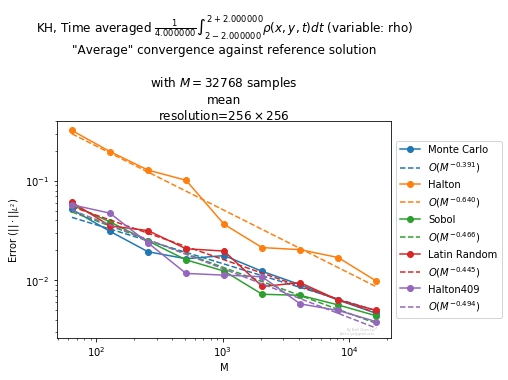

In [4]:
import glob
tauString = ['0.0625', '0.125', '0.25', '0.5', '1.0', '2.0']

for var in ['rho']:
    for n, tau in enumerate([0.0625, 0.125, 0.25, 0.5, 1, 2]):
        save.prefix='time_%s_%f' % (var, tau)
        display(HTML('<h1>Interval length = %f</h1>' % tau))
        allFiles = []
        #console_print("../configs_euler_brownian/N64/H_{}/euler_brownian*".format(H))
        #console_print(glob.glob("../configs_euler_brownian/N64/H_{}/euler_brownian*".format(H)))
        for f in glob.glob('../configs_euler_kh_timeaverage/N256/kelvinhelmholtz_time_4_*'):
            if not 'nieder' in f and not 'latin_center' in f:
                allFiles.append(f + "/m{M}/kelvinhelmholtz_identity_2.0_%s_mean_identity_0.nc" % tauString[n])
        
        
        
        for filename in allFiles:
            names = computeConvergence(filename, 2, 
                                       allFiles, var=var, 
                                       title_base='KH, Time averaged $\\frac{1}{%f}\\int_{2-%f}^{2+%f}\\rho(x,y,t) dt$' % (2*tau, tau, tau))
            
        for (figure_number, filename) in names.items():
            plt.figure(figure_number)
            legendLeft()
            save(filename)
        plt.show()
        
    
    
    

# Variance


# Mean examples Brownian


# Brownian initial data

Here we let the initial data be given as (truncated) Brownian motion, and we set
$$u^x_0(\omega, x,y) = B^1_{x,y}(\omega)\qquad u^y_0(\omega, x,y)=B^2_{x,y}(\omega)$$
for two independent two dimensional Brownian motions $B^1$ and $B^2$. We set the initial pressure and density to be constant.

In the approximation, we use $512^2$ dimensions. Not all QMC rules are able to handle this dimension, they are skipped.